# Pipeline

This pipeline includes all steps in a single notebook (For Google Colab setup and testing purposes). It is currently a work-in-progress, for now, please visit ./notebooks for the individual steps.

In [110]:
# If you are running this pipeline on Google Colab,
# please update ENVIRONMENT to "GOOGLE_COLAB".
# Otherwise, please update ENVIRONMENT to "LOCAL".

ENVIRONMENT = "LOCAL"

In [111]:
# Recommended to set to True if the data has changed,
# otherwise set to "False" to save time
BYPASS_CACHE = False

# Recommended to set to True if you want to refresh raw dataset
# from the source (Zip file), otherwise set to False to save time
FORCE_UNZIP = False

# Set the random seed for reproducibility
RANDOM_SEED = 42

# Set the test and evaluation sizes
TEST_SIZE = 0.2
EVAL_SIZE = 0.1

# Calculate the train size
TRAIN_SIZE = 1 - TEST_SIZE - EVAL_SIZE

In [112]:
# Set global directories
DEFAULT_DIR = "/content" if ENVIRONMENT == "GOOGLE_COLAB" else "."

DATA_DIR = f"{DEFAULT_DIR}/data"
DATASET_DIR = f"{DATA_DIR}/datasets"

# Caching
CACHE_DIR = f"{DATA_DIR}/cache"
DATASET_CACHE_DIR = f"{CACHE_DIR}/datasets"

# Datasets
TRAIN_DATA_DIR = f"{DATASET_DIR}/raw"
CLEANED_TRAIN_DATA_DIR = f"{DATASET_DIR}/cleaned"
PROCESSED_TRAIN_DATA_DIR = f"{DATASET_DIR}/processed"

# Set path to cache visualizations and models
VISUALIZATION_DIR = f"{CACHE_DIR}/visualizations"
MODEL_DIR = f"{CACHE_DIR}/models"
MACOS_DIR = f"{DEFAULT_DIR}/__MACOSX"

In [113]:
# Path to raw dataset
GOOGLE_DRIVE_DIR = f"{DEFAULT_DIR}/drive"
GOOGLE_DRIVE_ROOT_DIR = f"{GOOGLE_DRIVE_DIR}/MyDrive"

ZIP_FILE = "Furniture_Data.zip"

DATASET_ZIP = (
    f"{GOOGLE_DRIVE_ROOT_DIR}/{ZIP_FILE}"
    if ENVIRONMENT == "GOOGLE_COLAB"
    else f"{DEFAULT_DIR}/{ZIP_FILE}"
)

DATASET_EXTRACT_DIR = (
    f"{DEFAULT_DIR}/Furniture_Data" if ENVIRONMENT == "GOOGLE_COLAB" else DATASET_DIR
)

In [114]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

TF version: 2.16.1
Hub version: 0.16.1
GPU is NOT AVAILABLE


In [115]:
if ENVIRONMENT == "GOOGLE_COLAB":
    from google.colab import drive

    # Mount Google Drive
    drive.mount(GOOGLE_DRIVE_DIR, force_remount=True)

In [116]:
from tqdm import tqdm
import zipfile
import shutil
import os

# if force unzip or TRAIN_DATA_DIR doesn't exist or empty
if FORCE_UNZIP or not tf.io.gfile.exists(TRAIN_DATA_DIR):
    print("Starting unzip process...")
    # Extract the zip file
    with zipfile.ZipFile(DATASET_ZIP, "r") as zip_ref:
        zip_ref.extractall(DATASET_EXTRACT_DIR)
    print("Unzip process completed.")

    # Check if the new dataset already directory exists
    print("Checking for existing train dataset directory...")
    if os.path.isdir(TRAIN_DATA_DIR):
        # Delete the new dataset directory
        shutil.rmtree(TRAIN_DATA_DIR)
        print("Existing train dataset directory found and deleted.")

    print("Checking for `__MACOSX` directory...")
    # Check if the `__MACOSX` directory exists
    if os.path.isdir(MACOS_DIR):
        # Delete the `__MACOSX` directory
        shutil.rmtree(MACOS_DIR)
        print("`__MACOSX` directory found and deleted.")
    else:
        print("`__MACOSX` directory not found. Skipping deletion.")

    print("Moving extracted dataset to the correct directory...")
    # Move the extracted dataset to the correct directory
    if os.path.isdir(DATASET_EXTRACT_DIR):
        files = os.listdir(DATASET_EXTRACT_DIR)
        with tqdm(total=len(files), desc="Moving files") as pbar:
            for filename in files:
                shutil.move(os.path.join(DATASET_EXTRACT_DIR, filename), TRAIN_DATA_DIR)
                pbar.update(1)
    print("Dataset moved successfully.")
else:
    print("Skipping unzip process as TRAIN_DATA_DIR exists and FORCE_UNZIP is not set.")

Skipping unzip process as TRAIN_DATA_DIR exists and FORCE_UNZIP is not set.


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from PIL import ImageFile
import os, sys
from tqdm.auto import tqdm

In [118]:
data = tf.keras.utils.image_dataset_from_directory(TRAIN_DATA_DIR)

Found 255159 files belonging to 8 classes.


In [119]:
if ENVIRONMENT == "GOOGLE_COLAB":
    %pip install imagehash

In [120]:
import os
import pandas as pd
import imagehash
from PIL import Image
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import tensorflow as tf
import shutil


def image_category(directory):
    cat_list = pd.DataFrame(os.listdir(directory), columns=["Category"])
    for i in cat_list["Category"].values:
        if i == ".DS_Store" or i == "README.txt":
            cat_list.drop(cat_list[cat_list["Category"] == i].index, inplace=True)
    cat_list.reset_index(drop=True, inplace=True)
    return cat_list["Category"].values


def image_style(directory):
    style_list = os.listdir(f"{directory}/beds")
    style_list = [i for i in style_list if i not in [".DS_Store", "README.txt"]]
    return style_list


def image_style(directory):
    style_list = [
        i
        for i in os.listdir(f"{directory}/beds")
        if os.path.isdir(os.path.join(directory, "beds", i))
        and i not in [".DS_Store", "README.txt"]
    ]
    return style_list


def compute_hash(image_path):
    with Image.open(image_path) as img:
        hash_value = imagehash.average_hash(img)
    return hash_value


def imgSizeList(lists):
    imageSize = []
    size_counter = Counter()
    with tqdm(total=len(lists), desc="Getting image size") as pbar:
        for item in lists:
            with Image.open(item) as img:
                size = img.size
                imageSize.append(size)
                size_counter[size] += 1
            pbar.update(1)
    print("224x224 pixels: ", size_counter[(224, 224)])
    print("350x350 pixels: ", size_counter[(350, 350)])
    print(
        "Other size: ", len(lists) - size_counter[(224, 224)] - size_counter[(350, 350)]
    )
    return imageSize


def imgResize(lists, size):
    with tqdm(total=len(lists), desc="Resizing images") as pbar:
        for item in lists:
            with Image.open(item) as img:
                img1 = img.resize(size, resample=0)
                img1.save(item, "JPEG")
            pbar.update(1)


def image_duplicate(category, image_files):
    hashes = {}
    unique_images = []
    for image_file in tqdm(
        image_files,
        total=len(image_files),
        desc=f"Finding duplicate images in category '{category}'",
    ):
        try:
            image_hash = compute_hash(image_file)
        except PermissionError:
            print(f"Permission denied for file: {image_file}")
            continue

        if image_hash not in hashes:
            hashes[image_hash] = image_file
            unique_images.append(image_file)
    print(
        f"Category '{category}': Found {len(image_files) - len(unique_images)} duplicate images."
    )
    return unique_images


def img_dupChecks(lists, category):
    cleaned_dir = os.path.join(CLEANED_TRAIN_DATA_DIR, category)

    # Check if cleaned images have already been saved
    if os.path.exists(cleaned_dir) and os.listdir(cleaned_dir):
        print(f"Category '{category}': Cleaned images are already available.")
        return

    # Get unique images
    unique_images = image_duplicate(category, lists)

    # Save unique images to CLEANED_TRAIN_DATA_DIR
    os.makedirs(cleaned_dir, exist_ok=True)
    with tqdm(
        total=len(unique_images), desc=f"Saving unique images for category '{category}'"
    ) as pbar:
        for img_path in unique_images:
            shutil.copy(img_path, cleaned_dir)
            pbar.update(1)

    print(f"Category '{category}': Cleaned images saved successfully.")

In [121]:
# Define the categories
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]

# Extract paths for each category
paths = {category: image_path(TRAIN_DATA_DIR, category) for category in categories}

print("Successfully extracted all paths!")

Getting path: 0it [00:00, ?it/s]
Getting path: 0it [00:00, ?it/s]
Getting path: 0it [00:00, ?it/s]
Getting path: 0it [00:00, ?it/s]
Getting path: 0it [00:00, ?it/s]
Getting path: 0it [00:00, ?it/s]

Successfully extracted all paths!


In [122]:
# Calculate the total
total = 0

# Print the amount for each category
for category in categories:
    amount = len(paths[category])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 0
Amount of chairs: 0
Amount of dressers: 0
Amount of lamps: 0
Amount of sofas: 0
Amount of tables: 0
Total: 0


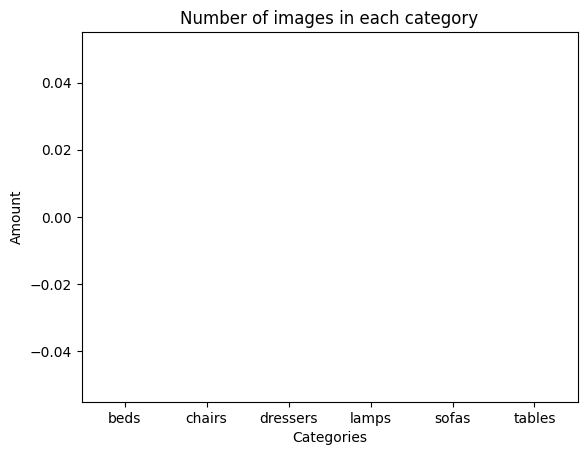

In [123]:
plt.bar(paths.keys(), [len(v) for v in paths.values()], width=0.5)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")
plt.show()

## Get duplicate images from each categories
### Check duplicants and remove duplicants from each categories

In [124]:
# Get the amount of duplicates and then remove them from the dataset
for category, path in paths.items():
    img_dupChecks(path, category)

# Update the paths to the cleaned paths
paths = {
    category: image_path(CLEANED_TRAIN_DATA_DIR, category) for category in categories
}

print("Successfully extracted all paths!")

Finding duplicate images in category 'beds': 0it [00:00, ?it/s]


Category 'beds': Found 0 duplicate images.


Saving unique images for category 'beds': 0it [00:00, ?it/s]


Category 'beds': Cleaned images saved successfully.


Finding duplicate images in category 'chairs': 0it [00:00, ?it/s]


Category 'chairs': Found 0 duplicate images.


Saving unique images for category 'chairs': 0it [00:00, ?it/s]


Category 'chairs': Cleaned images saved successfully.


Finding duplicate images in category 'dressers': 0it [00:00, ?it/s]


Category 'dressers': Found 0 duplicate images.


Saving unique images for category 'dressers': 0it [00:00, ?it/s]


Category 'dressers': Cleaned images saved successfully.


Finding duplicate images in category 'lamps': 0it [00:00, ?it/s]


Category 'lamps': Found 0 duplicate images.


Saving unique images for category 'lamps': 0it [00:00, ?it/s]


Category 'lamps': Cleaned images saved successfully.


Finding duplicate images in category 'sofas': 0it [00:00, ?it/s]


Category 'sofas': Found 0 duplicate images.


Saving unique images for category 'sofas': 0it [00:00, ?it/s]


Category 'sofas': Cleaned images saved successfully.


Finding duplicate images in category 'tables': 0it [00:00, ?it/s]


Category 'tables': Found 0 duplicate images.


Saving unique images for category 'tables': 0it [00:00, ?it/s]

Category 'tables': Cleaned images saved successfully.


### Recheck the categories after removing duplicants

In [125]:
print("Amount of bed: ", len(beds_path))
print("Amount of chair: ", len(chairs_path))
print("Amount of dresser: ", len(dressers_path))
print("Amount of lamp: ", len(lamps_path))
print("Amount of sofa: ", len(sofas_path))
print("Amount of table: ", len(tables_path))
print(
    "Total: ",
    len(beds_path)
    + len(chairs_path)
    + len(dressers_path)
    + len(lamps_path)
    + len(sofas_path)
    + len(tables_path),
)

NameError: name 'beds_path' is not defined

### Visualization

In [ ]:
image_Classes_modified = {
    "Beds": len(beds_path),
    "Chairs": len(chairs_path),
    "Dressers": len(dressers_path),
    "Sofas": len(sofas_path),
    "Lamps": len(lamps_path),
    "Tables": len(tables_path),
}

Text(0, 0.5, 'Amount')

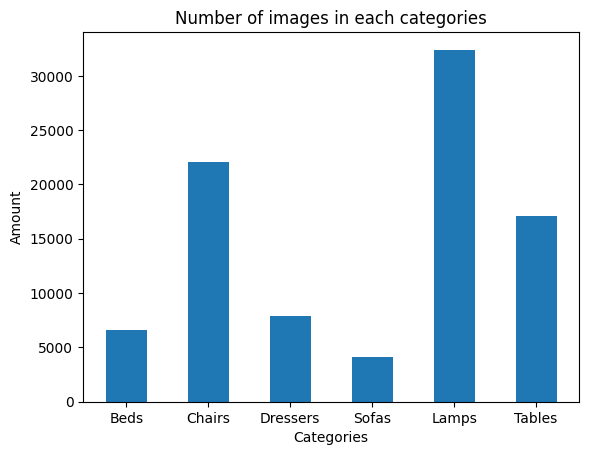

In [ ]:
plt.bar(image_Classes_modified.keys(), image_Classes_modified.values(), width=0.5)
plt.title("Number of images in each categories")
plt.xlabel("Categories")
plt.ylabel("Amount")

-   In the plot we can see the differences between of the amount in different columns. Because of that, we will need to check for the imbalances of our dataset

## Get different amount of image size of each category

In [ ]:
print("Beds")
df_bed_dims = pd.DataFrame(imgSizeList(beds_path), columns=["width", "height"])
print("Chairs")
df_chair_dims = pd.DataFrame(imgSizeList(chairs_path), columns=["width", "height"])
print("Dressers")
df_dresser_dims = pd.DataFrame(imgSizeList(dressers_path), columns=["width", "height"])
print("Lamps")
df_lamp_dims = pd.DataFrame(imgSizeList(lamps_path), columns=["width", "height"])
print("sofas")
df_sofa_dims = pd.DataFrame(imgSizeList(sofas_path), columns=["width", "height"])
print("Tables")
df_table_dims = pd.DataFrame(imgSizeList(tables_path), columns=["width", "height"])

Beds


Getting image size:   0%|          | 0/6578 [00:00<?, ?it/s]

224x224 pixels:  6537
350x350 pixels:  41
Other size:  0
Chairs


Getting image size:   0%|          | 0/22053 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  22053
Other size:  0
Dressers


Getting image size:   0%|          | 0/7871 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  7871
Other size:  0
Lamps


Getting image size:   0%|          | 0/32402 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  32402
Other size:  0
sofas


Getting image size:   0%|          | 0/4080 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  4080
Other size:  0
Tables


Getting image size:   0%|          | 0/17100 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  17099
Other size:  1


<Axes: xlabel='width', ylabel='height'>

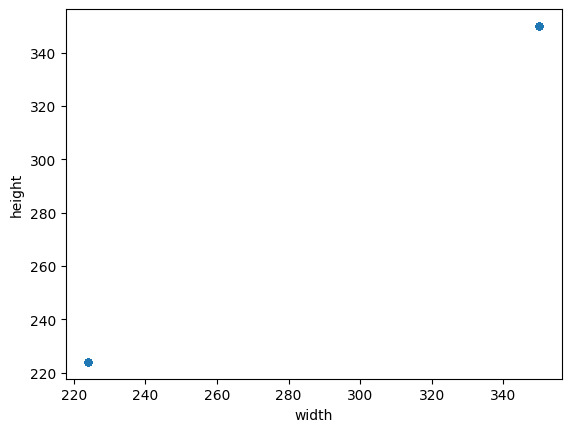

In [ ]:
df_bed_dims.plot.scatter(x="width", y="height")

<Axes: xlabel='width', ylabel='height'>

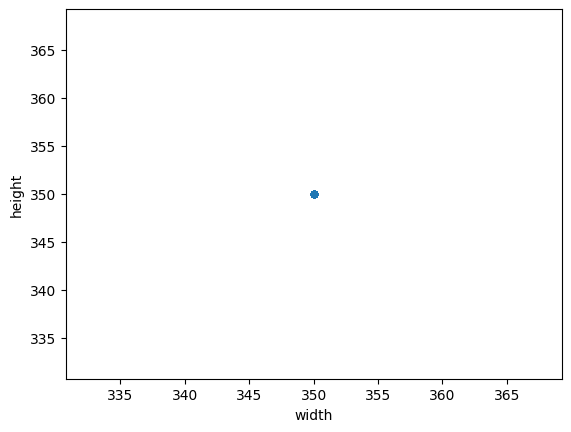

In [ ]:
df_chair_dims.plot.scatter(x="width", y="height")

<Axes: xlabel='width', ylabel='height'>

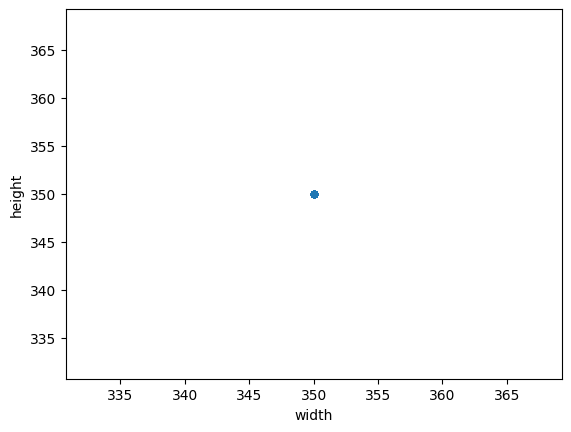

In [ ]:
df_dresser_dims.plot.scatter(x="width", y="height")

<Axes: xlabel='width', ylabel='height'>

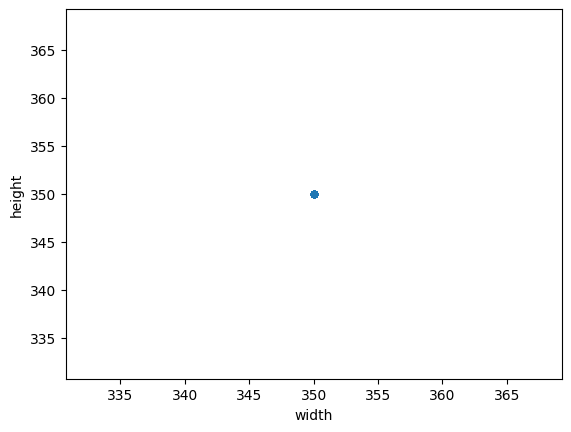

In [ ]:
df_lamp_dims.plot.scatter(x="width", y="height")

<Axes: xlabel='width', ylabel='height'>

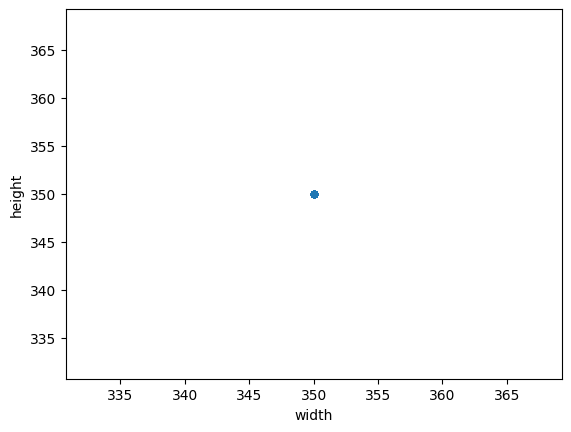

In [ ]:
df_sofa_dims.plot.scatter(x="width", y="height")

<Axes: xlabel='width', ylabel='height'>

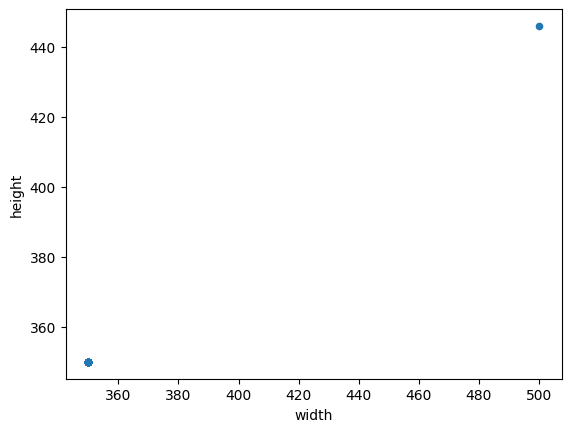

In [ ]:
df_table_dims.plot.scatter(x="width", y="height")

In [ ]:
df_table_dims.describe().T

,count,mean,std,min,25%,50%,75%,max
width,17100.0,350.008772,1.147079,350.0,350.0,350.0,350.0,500.0
height,17100.0,350.005614,0.734130,350.0,350.0,350.0,350.0,446.0


- The dataset contains 6 categories of items with 90083 items total
- The dataset contains all file with JPEG type
- The dataset contains image mainly in two dimensions: 224x224 and 350x350. However there are one anomaly dimensions in the table category which is: 500x446